# Run this code twice after the stage0 and stage0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='0'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('waveglow/')

import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import pickle as pkl
import torch
import torch.nn.functional as F
import hparams
from torch.utils.data import DataLoader
from modules.model import Model
from text import text_to_sequence, sequence_to_text
from denoiser import Denoiser
from tqdm import tqdm_notebook as tqdm
import librosa
from modules.loss import MDNLoss
import math
from multiprocessing import Pool
import numpy as np

data_type = 'char'
checkpoint_path = f"training_log/aligntts/stage0/checkpoint_40000"

from glob import glob

checkpoint_path = sorted(glob("training_log/aligntts/stage0/checkpoint_*"))[0]

print(checkpoint_path)


state_dict = {}
for k, v in torch.load(checkpoint_path)['state_dict'].items():
    state_dict[k[7:]]=v


model = Model(hparams).cuda()
model.load_state_dict(state_dict)
_ = model.cuda().eval()
criterion = MDNLoss()

training_log/aligntts/stage0/checkpoint_1000


In [2]:
import time

In [3]:
datasets = ['train', 'val', 'test']
batch_size=64
batch_size = 16

start = time.perf_counter()

for dataset in datasets:
    
    with open(f'filelists/ljs_audio_text_{dataset}_filelist.txt', 'r') as f:
        lines_raw = [line.split('|') for line in f.read().splitlines()]
        lines_list = [ lines_raw[batch_size*i:batch_size*(i+1)] 
                      for i in range(len(lines_raw)//batch_size+1)]
        
    for batch in tqdm(lines_list):
        
        single_loop_start = time.perf_counter()
        
        file_list, text_list, mel_list = [], [], []
        text_lengths, mel_lengths=[], []
        
        for i in range(len(batch)):
            file_name, _, text = batch[i]
            file_list.append(file_name)
            seq_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               f'{data_type}_seq')
            mel_path = os.path.join('../Dataset/LJSpeech-1.1/preprocessed',
                               'melspectrogram')
            try:
                seq = torch.from_numpy(np.load(f'{seq_path}/{file_name}_sequence.npy'))
            except FileNotFoundError:
                with open(f'{seq_path}/{file_name}_sequence.pkl', 'rb') as f:
                    seq = pkl.load(f)
            
            try:
                mel = torch.from_numpy(np.load(f'{mel_path}/{file_name}_melspectrogram.npy'))
            except FileNotFoundError:
                with open(f'{mel_path}/{file_name}_melspectrogram.pkl', 'rb') as f:
                    mel = pkl.load(f)
            
            text_list.append(seq)
            mel_list.append(mel)
            text_lengths.append(seq.size(0))
            mel_lengths.append(mel.size(1))
            
        io_time = time.perf_counter()
            
        text_lengths = torch.LongTensor(text_lengths)
        mel_lengths = torch.LongTensor(mel_lengths)
        text_padded = torch.zeros(len(batch), text_lengths.max().item(), dtype=torch.long)
        mel_padded = torch.zeros(len(batch), hparams.n_mel_channels, mel_lengths.max().item())
        
        for j in range(len(batch)):
            text_padded[j, :text_list[j].size(0)] = text_list[j]
            mel_padded[j, :, :mel_list[j].size(1)] = mel_list[j]
        
        text_padded = text_padded.cuda()
        mel_padded = mel_padded.cuda()
        text_lengths = text_lengths.cuda()
        mel_lengths = mel_lengths.cuda()
        
        with torch.no_grad():
            
            model_start = time.perf_counter()
            
            encoder_input = model.Prenet(text_padded)
            hidden_states, _ = model.FFT_lower(encoder_input, text_lengths)
            mu_sigma = model.get_mu_sigma(hidden_states)
            _, log_prob_matrix = criterion(mu_sigma, mel_padded, text_lengths, mel_lengths)
            
            viterbi_start = time.perf_counter()

            align = model.viterbi(log_prob_matrix, text_lengths, mel_lengths).to(torch.long)
            alignments = list(torch.split(align,1))
            
            viterbi_end = time.perf_counter()
        
        print('VT Time: ', end=' ')
        print(f'{viterbi_end - viterbi_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_end - viterbi_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('IO Time: ', end=' ')
        print(f'{io_time - single_loop_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(io_time - single_loop_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print('DL Time: ', end=' ')
        print(f'{viterbi_start - model_start:.6f} / {viterbi_end - single_loop_start:.6f} = ' +
             f'{(viterbi_start - model_start) / (viterbi_end - single_loop_start) * 100:5.2f}%')
        
        print(alignments[0].shape)
        
        break
        
        
        
       
#         for j, (l, t) in enumerate(zip(text_lengths, mel_lengths)):
#             alignments[j] = alignments[j][0, :l.item(), :t.item()].sum(dim=-1)
#             np.save(f'../Dataset/LJSpeech-1.1/preprocessed/alignments/{file_list[j]}_alignment.npy',
#                     alignments[j].detach().cpu().numpy())

VT Time:  0.758989 / 1.367927 = 55.48%
IO Time:  0.005540 / 1.367927 =  0.40%
DL Time:  0.591276 / 1.367927 = 43.22%
torch.Size([1, 170, 857])



VT Time:  0.590959 / 0.813022 = 72.69%
IO Time:  0.005205 / 0.813022 =  0.64%
DL Time:  0.213748 / 0.813022 = 26.29%
torch.Size([1, 140, 725])



VT Time:  0.759542 / 1.017219 = 74.67%
IO Time:  0.024682 / 1.017219 =  2.43%
DL Time:  0.226169 / 1.017219 = 22.23%
torch.Size([1, 137, 807])



In [4]:
print(log_prob_matrix.shape)

torch.Size([16, 137, 807])


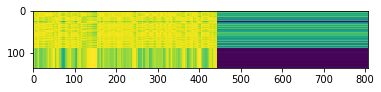

In [7]:
plt.imshow(log_prob_matrix[0, :, :].cpu())

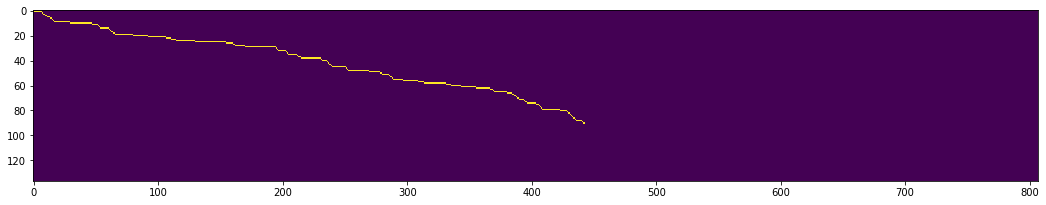

In [11]:
plt.figure(figsize=(18, 18))
plt.imshow(alignments[0][0, :, :].cpu())